# Quantum Code (Charlie)

<span style="font-size:1.2em;">*Notes:*</span>

Bottleneck in the speed of this code seems to be in constucting the superoperator and then solving the DE. May be able to speed up the construction of the superoperator by using multi-threading (https://docs.julialang.org/en/v1/manual/multi-threading/). Any feedback on how we can optimise this would be appreciated!

<span style="font-size:1.2em;">! Run this in **Julia** !</span> 

1. You'll need to install the Julia add on for Jupyter Notebooks (IJulia). Follow guide here: https://datatofish.com/add-julia-to-jupyter/
2. Go to *Kernel* -> *Change Kernel* -> *Julia*

## Packages

In [1]:
include("RCLib.jl") # Include the RC library with all the useful functions
using .RCLib

using LinearAlgebra # For IIL matrix multiplication
using OrdinaryDiffEq
using DifferentialEquations

using CSV # Allows data to be converted to .CSV to use with Python for plotting
using DataFrames # Another useful package for exporting data

## Variables

### Lorentzian Spectral Density

In [2]:
prm1 = [7.0 5.0 10.0];
prm2 = [1.4 0.5 0.16];
prm3 = [1.4 0.001 10];
prm4 = [3.5 5.0 10.0];
prm5 = [7.0 5.0 1.0];
prm6 = [7.0 5.0 0.01];
prm7 = [7.0 0.5 10.0];
prm8 = [0. 0.5 10.0];
prm9 = [7.0 5.0 100.0];
prm10 = [7.0 5.0 2000.0];
prm11 = [7.0 5.0 300.0];
prm12 = [7.0 5.0 700.0];
prm13 = [7.0 5.0 1200.0];
prm14 = [1.4 0.00001 10]; # Charlie

In [3]:
ω0, Γ, α = prm14*ωL;

### RC-Specific

In [4]:
Ω = ω0;
λ = ωL*sqrt(α/Ω);
δ = Γ/(2π*Ω);
n = 20;

### Environment

In [5]:
T = 1;

### Timescales

In [6]:
ti, tf, dt = 0, 12π, 0.15;
tspan = (ti, tf);
t = ti:dt:tf;

## Initial States

In [7]:
θ, ϕ = -π/2, 0; # Define some θ and ϕ on the Bloch sphere

In [8]:
state0 = ρ0(θ, ϕ, n, Ω, T);

## Solving the Master Equation

In [9]:
superop = 𝒮(n, Ω, λ, δ, T); # This is the superoperator corresponding to the Redfield master equation

In [10]:
alg = Vern7();

In [17]:
dstate(dρ, ρ, v, t) = mul!(dρ, superop, ρ); # Solves the DE
prob = ODEProblem(dstate, vec(state0), tspan);
sol = solve(prob, alg);

solRF(t) = transpose(reshape(sol(t), (2n, 2n))); # Reformats vector into a density matrix

expx(t) = real(tr(solRF(t)*kron(sx0, 𝕀b(n))));  # Sx expectation value
expy(t) = real(tr(solRF(t)*kron(sy0, 𝕀b(n)))); # Sy expectation value
expz(t) = real(tr(solRF(t)*kron(sz0, 𝕀b(n)))); # Sz expectation value

In [18]:
t = [i for i in t];
x = [expx(i) for i in t];
y = [expy(i) for i in t];
z = [expz(i) for i in t];

In [19]:
df = DataFrame(hcat(t, x, y, z), :auto);

In [21]:
CSV.write("rc_data.csv", df, header = ["t", "sx", "sy", "sz"]); # Exports RC data to a CSV file

<span style="font-size:1.2em;">! Run this in **Python** !</span>

Go to *Kernel* -> *Change Kernel* -> *Python*

In [1]:
import numpy as np
import numpy.random as rn
import scipy.stats as st
import scipy.fftpack as ft
import scipy.integrate as od
import scipy.signal as sig
import scipy.interpolate as intpl
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import tqdm as tqdm
import pickle
from scikits.odes.odeint import odeint

import sys
sys.path.append("C://Users//crh222//phd//python//rc")
import ASHLib as myLib
from importlib import reload
reload(myLib)

# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"  #"Times New Roman"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
#rc('text', usetex=True)

In [2]:
import pandas as pd

In [3]:
data = np.array(pd.read_csv(r'rc_data.csv')) 

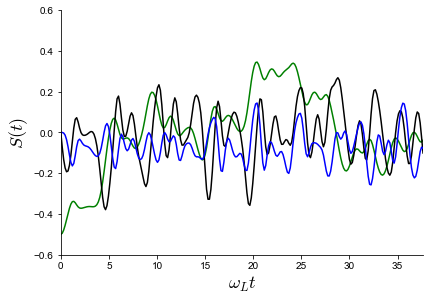

In [5]:
figRC, axRC = plt.subplots(figsize=(6.5, 4.5))  #size in inches

# labeling
axRC.spines["top"].set_visible(False)
axRC.spines["right"].set_visible(False)
axRC.get_xaxis().tick_bottom()
axRC.get_yaxis().tick_left()

axRC.set_xlim(-0, 12 * np.pi)
axRC.set_ylim(-0.6, 0.6)
axRC.set_xlabel("$\omega_L t$", fontsize=18)
axRC.set_ylabel("$S(t)$", fontsize=18)

##### data ######

axRC.plot(data[:,0], data[:, 1], 'g-')
axRC.plot(data[:,0], data[:, 2], 'k-')
axRC.plot(data[:,0], data[:, 3], 'b-')

plt.savefig("C://Users//crh222//Dropbox//PhD//1. Quantum Treatment//Techniques//Reaction Coordinate Mapping//Graphs//rc_graph.png", dpi=300)

# Semiclassical Code (ASH)

## Imports

In [6]:
%matplotlib notebook

import os
import ipyparallel as ipp

remote_cluster = ipp.Client()  # create cluster object
print(remote_cluster.ids)  # print the active engines in the cluster

dview = remote_cluster[:]  # give a name to address all engines

# a_remote_cluster = dview.apply_async(os.getpid)
# pid_map = a_remote_cluster.get_dict()

# configure of the cells as blocks, therefore "sequentials"
# you need to specify "--noblock" to make the engines work simultaneously. See later example.
# %pxconfig --block

[0, 1, 2, 3]


In [7]:
%%px
# every engine imports the libraries
# (cant use sync_import() because "import ... as ..." does not work - "hook" issue)

import numpy as np
import numpy.random as rn
import scipy.stats as st
import scipy.fftpack as ft
import scipy.integrate as od
import scipy.signal as sig
import scipy.interpolate as intpl
import matplotlib.pyplot as plt
import tqdm as tqdm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
import matplotlib
import pickle
from scikits.odes.odeint import odeint

import sys
sys.path.append("C://Users//crh222//phd//python//rc")
import ASHLib as myLib
from importlib import reload
reload(myLib)

# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"  #"Times New Roman"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
#rc('text', usetex=True)

## Initial Conditions

In [8]:
def initial_conditions(x):
    return np.sqrt(1 - x**2)

print("S_z = ", initial_conditions(0.6)) # check file for confirmation

S_z =  0.8


## Update Parameters

In [9]:
tmax_new = 100 # 7200 prm1 - 72000 prm5 - 500 prm9
scale_new = 1 # usually 200 for spin S01

dview.push(dict(tmax_new = tmax_new, scale_new = scale_new))

myLib.update_parameters(tmax_new, scale_new)
%px myLib.update_parameters(tmax_new, scale_new)

## Parameters

In [10]:
%%px

# Kernel parameters w0, Gam, A
prm1 = [7.0, 5.0, 10.0]
prm2 = [1.4, 0.5, 0.16]
prm3 = [1.4, 0.001, 10]
prm4 = [3.5, 5.0, 10.0]
prm5 = [7.0, 5.0, 1.0]
prm6 = [7.0, 5.0, 0.01]
prm7 = [7.0, 0.5, 10.0]
prm8 = [0., 0.5, 10.0]
prm9 = [7.0, 5.0, 100.0]
prm10 = [7.0, 5.0, 2000.0]
prm11 = [7.0, 5.0, 300.0]
prm12 = [7.0, 5.0, 700.0]
prm13 = [7.0, 5.0, 1200.0]
prm14 = [1.4, 0.00001, 10] # Charlie

# eta/w_L^2 in the paper - Gilbert damping parameter
lamR1 = prm1[2] * prm1[1] / prm1[0]**4
lamR2 = prm2[2] * prm2[1] / prm2[0]**4
#etc..

In [11]:
prm1 = dview.pull('prm1', targets=0).get()
prm2 = dview.pull('prm2', targets=0).get()
prm3 = dview.pull('prm3', targets=0).get()
prm4 = dview.pull('prm4', targets=0).get()
prm5 = dview.pull('prm5', targets=0).get()
prm6 = dview.pull('prm6', targets=0).get()
prm7 = dview.pull('prm7', targets=0).get()
prm8 = dview.pull('prm8', targets=0).get()
prm9 = dview.pull('prm9', targets=0).get()
prm10 = dview.pull('prm10', targets=0).get()
prm11 = dview.pull('prm11', targets=0).get()
prm12 = dview.pull('prm12', targets=0).get()
prm13 = dview.pull('prm13', targets=0).get()
prm14 = dview.pull('prm14', targets=0).get()
prm15 = dview.pull('prm15', targets=0).get()

In [12]:
%%px

# angle of the stochastic field in Purkayastha paper
angle_b_stochastic = np.pi / 4

matrix_c_w = np.array([[1, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]])

# 1 stochastic field at angle theta in the x-z plane (dimension=1)
# matrix_c_w = np.array([[-np.sin(angle_b_stochastic), 0, 0],
#                        [0, 0, 0],
#                        [np.cos(angle_b_stochastic), 0, 0]])

# 2 independent stochastic fields, one in x and one in the z direction (dimension=2)
# matrix_c_w = np.array([[1, 0, 0],
#                        [0, 0, 0],
#                        [0, 0, 1]])

# 3 independent stochastic fields, directions x, y, z (dimension=3)
# matrix_c_w = np.array([[1, 0, 0],
#                        [0, 1, 0],
#                        [0, 0, 1]])

# Number of temperature points
Nplt = 12

# Number of iterations for each engine (for speeding up single run)
# roughly: Nplt / num_engines
n_split = 1

# Spin magnitude values
scale = myLib.scale  # scale between two spin magnitudes

S02 = myLib.S02
S01 = myLib.S01 #S01 is the larger one!!!

# dimensionless temperature
barT2 = myLib.barT2  # use for spin S02
barT1 = myLib.barT1  # use for spin S01 #T1 is the larger one!!!

# (non-Kelvin) temperature axes for spin S01 and S02. Multiply by cfac to convert to Kelvin
lT = 0
uT = 1.5 # uT = 300 for spin=200 (S01) || uT = 1.5 for spin=1 (S02)

# linear scales
barTva = np.linspace(lT, scale * uT, Nplt) # S01
barTvb = np.linspace(lT, uT, Nplt) # S02

# log scales
barTva_log = np.logspace(-3, 3, Nplt)
barTva_log = [scale * barTva_log[i] / myLib.cfac for i in range(len(barTva_log))]
barTva_log = np.array(barTva_log)

barTvb_log = np.logspace(-3, 3, Nplt)
barTvb_log = [barTvb_log[i] / myLib.cfac for i in range(len(barTvb_log))]
barTvb_log = np.array(barTvb_log)

alpha_log = np.logspace(-3, 3, 7)

# choose small offset to avoid numerical divergence at T=0
# for analytical classical M(T) curve and numerical classical M(T) curve
# (can also make if-loop and give analytical value at T=0)
offset = 0.00001

In [13]:
%%px

# # this creates extra points equally spaced in log-scale for the temperature range

array_tmp = [np.log10(barTvb_log[i]) for i in range(len(barTvb_log))]
array_increment = (array_tmp[8] - array_tmp[5]) / 4
tmp = np.array([(array_tmp[5] + array_increment),
                (array_tmp[5] + 2 * array_increment),
                (array_tmp[5] + 3 * array_increment)])
tmp = [10**tmp[i] for i in range(len(tmp))]

barTvb_log_paper = np.concatenate((barTvb_log[0:6], tmp))
barTvb_log_paper = np.concatenate((barTvb_log_paper, barTvb_log[8:12]))

In [14]:
barTva = dview.pull('barTva', targets=0).get()
barTvb = dview.pull('barTvb', targets=0).get()
barTva_log = dview.pull('barTva_log', targets=0).get()
barTvb_log = dview.pull('barTvb_log', targets=0).get()
barTvb_log_paper = dview.pull('barTvb_log_paper', targets=0).get()

## Noise

In [15]:
# 3 sets of Gaussian white noise (SAME NOISE for all kernels)
# use this to speed up a single run

nssx = rn.normal(scale=1.0 / np.sqrt(myLib.dt), size=(myLib.N_extended, 1))
nssy = rn.normal(scale=1.0 / np.sqrt(myLib.dt), size=(myLib.N_extended, 1))
nssz = rn.normal(scale=1.0 / np.sqrt(myLib.dt), size=(myLib.N_extended, 1))

dview.push(dict(nssx=nssx))
dview.push(dict(nssy=nssy))
dview.push(dict(nssz=nssz))

<AsyncResult: _push>

## Spin Dynamics

### Noise Preparation

In [16]:
%%px

# set arrays for 3 spin components
Ncomp = 3
Noff = myLib.N - 3

In [17]:
n_runs = 2

nssx = rn.normal(scale=1.0 / np.sqrt(myLib.dt), size=(myLib.N_extended, 1, n_runs))
nssy = rn.normal(scale=1.0 / np.sqrt(myLib.dt), size=(myLib.N_extended, 1, n_runs))
nssz = rn.normal(scale=1.0 / np.sqrt(myLib.dt), size=(myLib.N_extended, 1, n_runs))

dview.push(dict(n_runs=n_runs))
dview.push(dict(nssx=nssx))
dview.push(dict(nssy=nssy))
dview.push(dict(nssz=nssz))

<AsyncResult: _push>

### Simulations

In [18]:
%%px --target 0 --noblock

dyn_0 = myLib.avg_dynamics(1.0/myLib.cfac, S02, prm14, 1, nssx, nssy, nssz, "quantum", matrix_c_w, n_runs)

<AsyncResult: execute>

In [19]:
%%px --target 1 --noblock

dyn_1 = myLib.avg_dynamics(1.0/myLib.cfac, S02, prm14, 1, nssx, nssy, nssz, "quantum", matrix_c_w, n_runs)

<AsyncResult: execute>

In [20]:
%%px --target 2 --noblock

dyn_2 = myLib.avg_dynamics(1.0/myLib.cfac, S02, prm14, 1, nssx, nssy, nssz, "quantum", matrix_c_w, n_runs)

<AsyncResult: execute>

In [21]:
%%px --target 3 --noblock

dyn_3 = myLib.avg_dynamics(1.0/myLib.cfac, S02, prm14, 1, nssx, nssy, nssz, "quantum", matrix_c_w, n_runs)

<AsyncResult: execute>

In [26]:
Out[18].display_outputs()

In [27]:
# load the results just generated
dyn_0 = dview.pull('dyn_0', targets=0).get()
dyn_1 = dview.pull('dyn_1', targets=1).get()
dyn_2 = dview.pull('dyn_2', targets=2).get()
dyn_3 = dview.pull('dyn_3', targets=3).get()

dyn_avg = myLib.avg_data(dyn_0, dyn_1, dyn_2, dyn_3)
np.savetxt("ASH_data.csv", dyn_avg, delimiter=",")

In [28]:
%%px

# Plot parameters

# time axis shifted to positive times for plotting (last term to undo the rounding error)
# tvash = myLib.tva[0 : myLib.N]
# tvash = myLib.tva[0 : myLib.N] + myLib.tmax/2

# CORRECT VERSION
tvash = myLib.tva[0 : myLib.N] + myLib.tmax / 2 - (myLib.tmax - myLib.N * myLib.dt) / 2

# figure parameters
sz = 12  #small size
fz = 14  #fontsize
lz = 18  #labelsize
# tsh = 1
tpl = myLib.tmax / 2 / np.pi

# print(f'dt:\n{dt}')
# print(f'tmax:\n{tmax}')
# print(f'N:\n{N}')
# print(f'tva[0]:\n{tva[0]}')
# print("tvash: ",tvash)

In [29]:
tmax = myLib.tmax
dt = myLib.dt
hbar = myLib.hbar
cfac = myLib.cfac

S01 = dview.pull('S01', targets=0).get()
S02 = dview.pull('S02', targets=0).get()
barT1 = dview.pull('barT1', targets=0).get()
barT2 = dview.pull('barT2', targets=0).get()
tvash = dview.pull('tvash', targets=0).get()
sz = dview.pull('sz', targets=0).get()
fz = dview.pull('fz', targets=0).get()
lz = dview.pull('lz', targets=0).get()
tpl = dview.pull('tpl', targets=0).get()

<IPython.core.display.Javascript object>


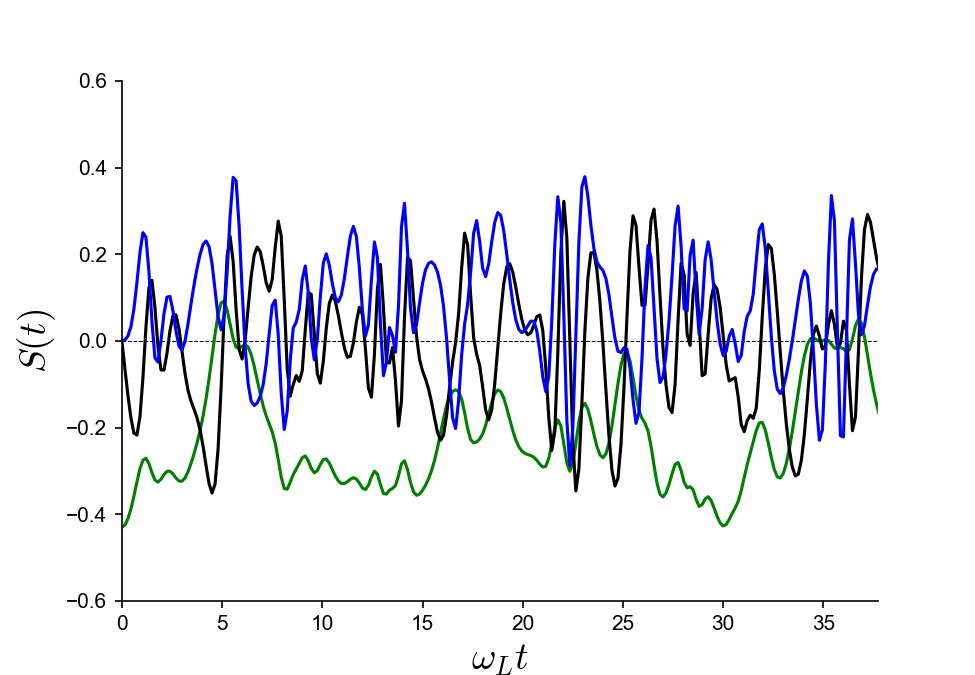

In [30]:
figASH, axASH = plt.subplots(figsize=(6.5, 4.5))  #size in inches

# labeling
axASH.spines["top"].set_visible(False)
axASH.spines["right"].set_visible(False)
axASH.get_xaxis().tick_bottom()
axASH.get_yaxis().tick_left()
axASH.plot([0, tmax - 4 * dt], [0, 0], 'k--', lw=0.5)

axASH.set_xlim(-0 * dt, 12 * np.pi)
axASH.set_ylim(-0.6, 0.6)
axASH.set_xlabel("$\omega_L t$", fontsize=18)
axASH.set_ylabel("$S(t)$", fontsize=18)

##### data ######

axASH.plot(tvash, 0.5*0.86*dyn_avg[:, 0], 'g-')
axASH.plot(tvash, 0.5*0.86*dyn_avg[:, 1], 'k-')
axASH.plot(tvash, 0.5*0.86*dyn_avg[:, 2], 'b-')

plt.savefig("C://Users//crh222//Dropbox//PhD//1. Quantum Treatment//Techniques//Reaction Coordinate Mapping//Graphs//ASH_graph.png", dpi=300)

<IPython.core.display.Javascript object>


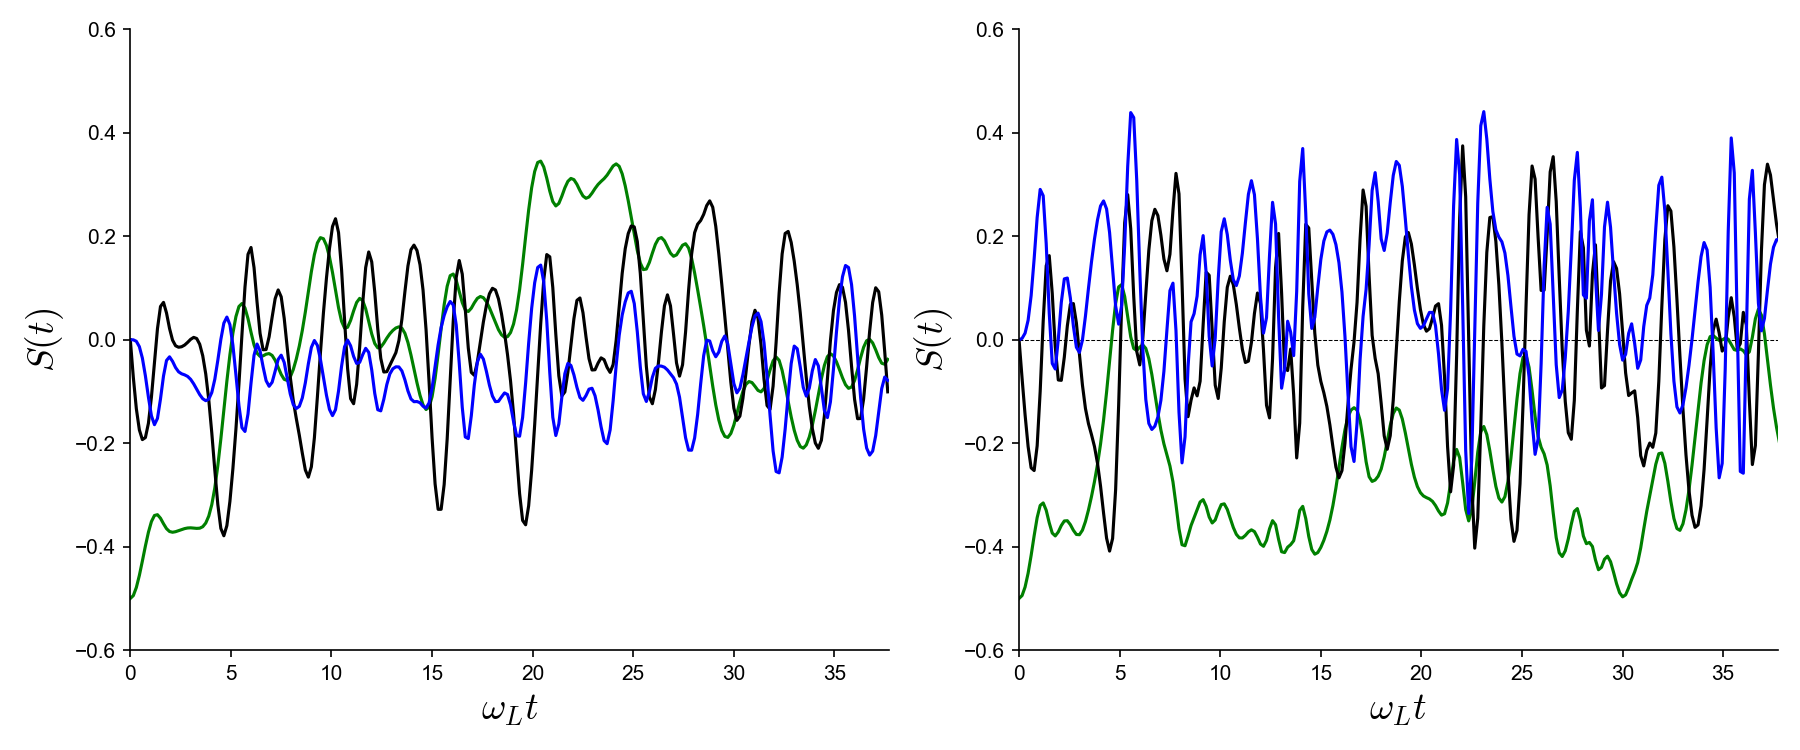

In [31]:
# Note: choose small tmax above to see short time oscillations/differences between kernel-dyn and LLG-dyn
# standard LLG curves rely on prm1 and prm2 giving same lambda==eta

figComp, bxComp = plt.subplots(1, 2, figsize=(12, 5))  #size in inches

#############################
######### top left ##########
#############################

# labeling
bxComp[0].spines["top"].set_visible(False)
bxComp[0].spines["right"].set_visible(False)
bxComp[0].get_xaxis().tick_bottom()
bxComp[0].get_yaxis().tick_left()

bxComp[0].set_xlim(-0, 12 * np.pi)
bxComp[0].set_ylim(-0.6, 0.6)
bxComp[0].set_xlabel("$\omega_L t$", fontsize=18)
bxComp[0].set_ylabel("$S(t)$", fontsize=18)

##### data ######

bxComp[0].plot(data[:,0], data[:, 1], 'g-')
bxComp[0].plot(data[:,0], data[:, 2], 'k-')
bxComp[0].plot(data[:,0], data[:, 3], 'b-')

#############################
######### top right #########
#############################

# see above for key to these plots

bxComp[1].spines["top"].set_visible(False)
bxComp[1].spines["right"].set_visible(False)
bxComp[1].get_xaxis().tick_bottom()
bxComp[1].get_yaxis().tick_left()
bxComp[1].plot([0, tmax - 4 * dt], [0, 0], 'k--', lw=0.5)

bxComp[1].set_xlim(-0 * dt, 12 * np.pi)
bxComp[1].set_ylim(-0.6, 0.6)
bxComp[1].set_xlabel("$\omega_L t$", fontsize=18)
bxComp[1].set_ylabel("$S(t)$", fontsize=18)

##### data ######

bxComp[1].plot(tvash, 0.5*dyn_avg[:, 0], 'g-')
bxComp[1].plot(tvash, 0.5*dyn_avg[:, 1], 'k-')
bxComp[1].plot(tvash, 0.5*dyn_avg[:, 2], 'b-')

plt.tight_layout()
plt.savefig("C://Users//crh222//Dropbox//PhD//1. Quantum Treatment//Techniques//Reaction Coordinate Mapping//Graphs//comp_graph.png", dpi=300)